In [101]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN, tcn_full_summary

# Copy Memory

In this task, each input sequence has length T + 20. The first 10 values are chosen randomly among the digits 1, . . . , 8, with the rest being all zeros, except for the last 11 entries that are filled with the digit ‘9’ (the first ‘9’ is a delimiter). The goal is to generate an output of the same length that is zero everywhere except the last 10 values after the delimiter, where the model is expected to repeat the 10 values it encountered at the start of the input.

Ex.

Input  = 1234567876 000000000 99999999999 
         
         Message        T     Delimeter+Space

Output = 0000000000 000000000 01234567876

                              Message


In [2]:
def CreateCopyMemoryDataset(T, ENTRIES):
    """
    Inputs:
    T       (INT): The number of 0s between the message and delimeter
    ENTRIES (INT): The number of copy memory example entries to make
    
    Outputs:
    X       (np.array, shape:(Entries, T+20)): Copy memory input sequences
    y       (np.array, shape:(Entries, T+20)): Copy memoty output sequences
    """
    
    #Create random integer messages
    RandIntMessages = np.random.randint(low=1, high=8, size=((ENTRIES, 10)))
    
    #Create delimeter
    Delimeter = np.zeros((ENTRIES, 11)) + 9
    
    #Create spacer
    Spacer = np.zeros((ENTRIES, T-1))
    
    #Create X
    # [Message, Spacer, Delimeter]
    X = np.hstack((RandIntMessages, Spacer, Delimeter))
    
    #Create empty array for y,then transplant the X messages to the correct location
    y = np.zeros((ENTRIES, T+20))
    y [:, -10:] = X[:,:10]
        
    return X, y

In [4]:
X, y = CreateCopyMemoryDataset(3, 10)
print(X.shape)
print(y.shape)

print(X[0])
print(y[0])

(10, 23)
(10, 23)
[7. 6. 3. 7. 4. 2. 7. 6. 5. 2. 0. 0. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 7. 6. 3. 7. 4. 2. 7. 6. 5. 2.]


# TCN

Implmenting TCN using: ["https://github.com/philipperemy/keras-tcn"]



In [276]:
def buildTCNModel(T):
    """
    Inputs:
    T   (INT): The number of spaces in the sequence
    
    Outputs:
    TCNMdoel: Compiled TCN model (tf.keras.Model)
    """
    #Setup TCN architecture
    tcn_layer = TCN(
        input_shape =(T+20,1),
        nb_filters=32,
        kernel_size=4,
        nb_stacks=1,
        dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.1,
        return_sequences=True,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=False,
        use_layer_norm=False,
        use_weight_norm=True
    )

    #Create a Tensorflow model
    TCNModel = tf.keras.models.Sequential([tcn_layer, tf.keras.layers.Dense(1)])
    
    #Setup model
    TCNModel.compile(optimizer="adam", loss="mse")
    
    return TCNModel

# Training and Testing

Proof of concept applying Copy Memory to T=10 

In [210]:
#Define Copy Memory Problem
T = 10

#Create Training Examples
ENTRIES = 10000
X, y = CreateCopyMemoryDataset(T, ENTRIES)
print(X.shape)
print(y.shape)

#Build Model
TCNModel = buildTCNModel(T)

(10000, 30)
(10000, 30)


In [255]:
#Train Model
history = TCNModel.fit(x=X, y=y, epochs = 10,
                      batch_size = 128, steps_per_epoch = 16)

Epoch 1/10
16/16 [==============================] - 1s 55ms/step - loss: 0.1025 - categorical_crossentropy: 87.6045
Epoch 2/10
16/16 [==============================] - 1s 58ms/step - loss: 0.0957 - categorical_crossentropy: 86.4459
Epoch 3/10
16/16 [==============================] - 1s 56ms/step - loss: 0.0950 - categorical_crossentropy: 87.8052
Epoch 4/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0899 - categorical_crossentropy: 86.8595
Epoch 5/10
16/16 [==============================] - 1s 53ms/step - loss: 0.0885 - categorical_crossentropy: 87.6367
Epoch 6/10
16/16 [==============================] - 1s 56ms/step - loss: 0.0896 - categorical_crossentropy: 87.7997
Epoch 7/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0845 - categorical_crossentropy: 86.9424
Epoch 8/10
16/16 [==============================] - 1s 57ms/step - loss: 0.0813 - categorical_crossentropy: 86.9184
Epoch 9/10
16/16 [==============================] - 1s 55ms/step - loss:

In [256]:
#Create an example and have the trained model predict the output
X, y = CreateCopyMemoryDataset(T, 1)
pred_y = TCNModel.predict(X)

print("Input Sequnce:")
print(y[:,-10:])
print("Output Sequence")
print(np.round(pred_y).reshape(1,-1)[:,-10:])
print("Unrounded-Output Sequnce:")
print(np.round(pred_y,2).reshape(1,-1)[:,-10:])


Input Sequnce:
[[1. 7. 5. 4. 1. 2. 2. 6. 4. 2.]]
Output Sequence
[[1. 7. 5. 4. 1. 2. 2. 6. 4. 2.]]
Unrounded-Output Sequnce:
[[0.87 6.56 4.77 3.72 0.83 1.71 1.87 5.65 3.82 1.95]]


For this problem, an important metric to track is accuracy. There isn't an "off the shelf" metric from TensorFlow that is exactly what we need, so we need to write a custom metric that rounds the output and quantifies the number of errors between the input and output sequence 

In [283]:
def TCNAccuracy(model, T):
    """
    Inputs
    model: A TCN Model
    T   (INT): The number of spaces in the sequence
    
    Outputs:
    acc (float, [0, 1]): The model's accuracy defined as incorrect digits over total digits for 1000 attempts
    """
    
    #Create Examples
    X, y = CreateCopyMemoryDataset(T, 500)
    
    #Predict on Examples
    pred_y = model.predict(X)
    
    #Round predictions
    pred_y = np.round(pred_y)
        
    #Count up all digits
    m, n = X.shape
    digits = m*n
    
    #Count up misses
    misses = 0
    for i in range(m):
        for j in range(n):
            if pred_y[i,j] != y[i,j]:
                misses+=1
            
    
    #Calculate Accuracy
    acc = 1 - (misses / digits) 
    
    return acc

In [291]:
import tensorflow.keras.backend as K
import sklearn.metrics as sklm

class Metrics(tf.keras.callbacks.Callback):
    
    #Initiate a metric for CopyMemAcc to store throughout training
    def on_train_begin(self, logs={}):
        self.CopyMemAcc=[0]
    
    #After each epoch, calculate the accuracy
    def on_epoch_end(self, epoch, logs={}):
        
        #Get accuracy
        T = self.model.input_shape[1] -20
        acc = TCNAccuracy(self.model, T)
        
        #Store epoch's CopyMemAcc
        self.CopyMemAcc.append(acc)
        return
    
Metric = Metrics()

In [292]:
#Define Copy Memory Problem
T = 10

#Create Training Examples
X, y = CreateCopyMemoryDataset(T, 10000)

#Build Model
TCNModel = buildTCNModel(T)

history = TCNModel.fit(x=X, y=y, epochs = 50,
                      batch_size = 16, steps_per_epoch = 8,
                      callbacks = [Metric])

#Check custom accuracy metric 
print(Metric.CopyMemAcc)

(10000, 30)
(10000, 30)
Epoch 1/50
8/8 [==============================] - 5s 25ms/step - loss: 5.2945
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 2.5180
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 1.6542
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 1.3113
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.9779
Epoch 6/50
8/8 [==============================] - 0s 19ms/step - loss: 0.8120
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.7094
Epoch 8/50
8/8 [==============================] - 0s 17ms/step - loss: 0.6353
Epoch 9/50
8/8 [==============================] - 0s 16ms/step - loss: 0.5843
Epoch 10/50
8/8 [==============================] - 0s 16ms/step - loss: 0.4921
Epoch 11/50
8/8 [==============================] - 0s 20ms/step - loss: 0.4935
Epoch 12/50
8/8 [==============================] - 0s 21ms/step - loss: 0.4838
Epoch 13/50
8/8 [====================

# Receptive Field Analysis

TCN Networks are great at providing a large receptive field to provide insight into future predections and effectively transfering information from far away inputs. Effectively, they have a long memory and can apply it effectively. 

Trained and Tested T=5
Trained and Tested T=25
Trained and Tested T=50
Trained and Tested T=100
Trained and Tested T=500


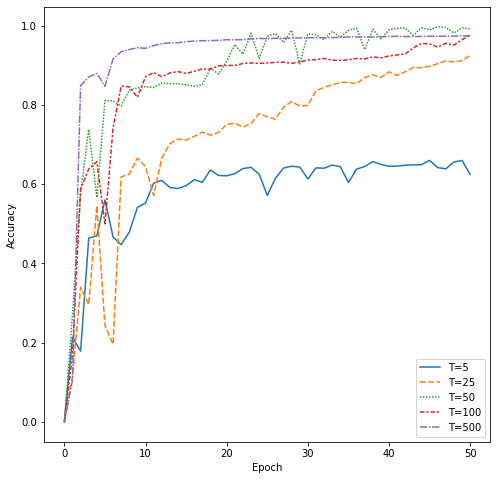

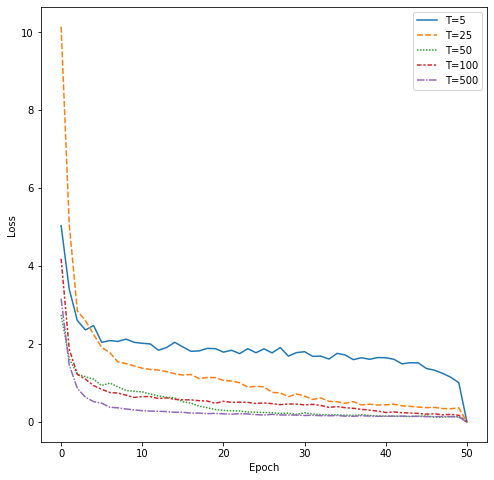

In [321]:
def TCN_T_Test(TList, Metrics = Metrics()):
    """
    Inputs:
    T: A list of integers defining at what intervals of T to test the TCN architecture
    
    Outputs:
    accDF : A pandas dataframe tracking accuracy over training iterations
    lossDF: A pandas dataframe tracking loss over training iterations
    """
    EPOCHS=50
    Train_Accuracies = np.zeros((EPOCHS+1, len(TList)))
    Train_Losses = np.zeros((EPOCHS+1, len(TList)))
    
    #Repeat example generation, training, and testing at each interval T
    for i, T in enumerate(TList):
        
        #Create Training examples
        X, y = CreateCopyMemoryDataset(T, 10000)
        
        #Create Model
        TCNModel = buildTCNModel(T)
                
        #Train Model
        history = TCNModel.fit(x=X, y=y, epochs = EPOCHS,
                      batch_size = 16, steps_per_epoch = 5, verbose=0,
                      callbacks = [Metrics])
        
        #Store loss and accuracies over training epochs
        Train_Accuracies[:,i] = np.squeeze(np.array(Metrics.CopyMemAcc).reshape(-1,1))
        Train_Losses[:,i] = history.history["loss"]+[0.0]
        print("Trained and Tested T="+str(T))

    
    
    #Plot Results
    AccDF = pd.DataFrame(Train_Accuracies, columns=["T="+str(TList[i]) for i in range(len(TList))])
    LossDF = pd.DataFrame(Train_Losses, columns=["T="+str(TList[i]) for i in range(len(TList))])
    
    ax = plt.figure(figsize=(8,8))
    ax = sns.lineplot(data = AccDF)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")

    
    
    ax = plt.figure(figsize=(8,8))
    ax = sns.lineplot(data = LossDF)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    
    return AccDF, LossDF


T=[5,25,50,100,500]
AccDF, LossDF= TCN_T_Test(T)


Oddly enough, the model struggled to handle the smaller examples, where T<5. Likely the model is too big for smaller T scenarios, ie. too many filters, too many layers, and too large of filters. It would have made more sense to adjust the number of filters and fiter size based on the size T of given input. Also, it's hard to actually detect whether the network is preforming well or just giving an output sequence of only 0s, which would score much higher proportionally for larger values of T. 

Let's update the buildTCNModel to have more stacks and filters, and then apply it to larger T values.

Trained and Tested T=100
Trained and Tested T=500
Trained and Tested T=750
Trained and Tested T=1000


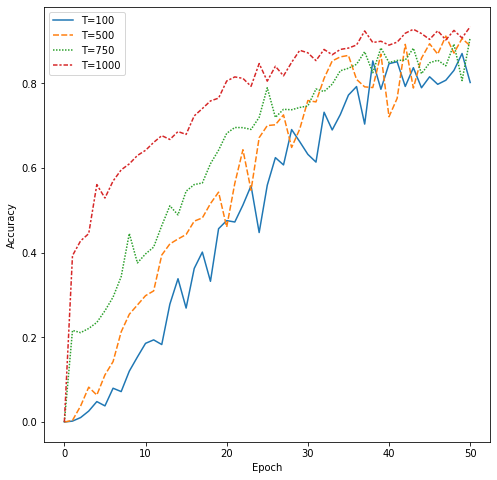

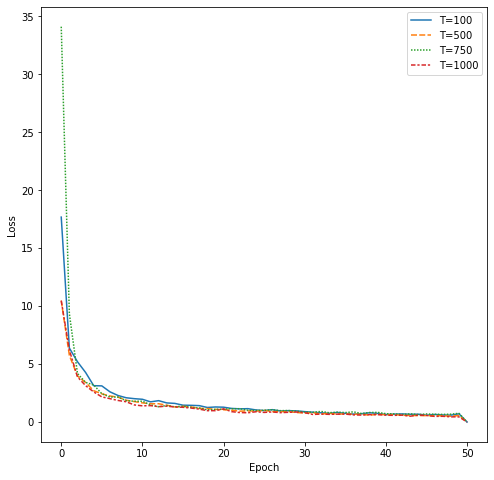

In [323]:
#Build a larger sized model
def buildTCNModel(T):
    """
    Inputs:
    T   (INT): The number of spaces in the sequence
    
    Outputs:
    TCNMdoel: Compiled TCN model (tf.keras.Model)
    """
    #Setup TCN architecture
    tcn_layer = TCN(
        input_shape =(T+20,1),
        nb_filters=64,
        kernel_size=4,
        nb_stacks=2,
        dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.1,
        return_sequences=True,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=True,
        use_layer_norm=False,
        use_weight_norm=False
    )

    #Create a Tensorflow model
    TCNModel = tf.keras.models.Sequential([tcn_layer, tf.keras.layers.Dense(1)])
    
    #Setup model
    TCNModel.compile(optimizer="adam", loss="mse")
    
    return TCNModel


T=[100, 500, 750, 1000]

AccDF, LossDF= TCN_T_Test(T)

Likely the best approach for a problem like this would to include nb_filters, kernel_size, nb_stacks, and dilatations as inputs and adjust the parameters to make the receptive field equal to or slightly greater than the input sequence length (T+20). This would ensure inputs from the begining of the sequence (Where the original message is held) can be transferred to the end of the output sequences. Also, limiting the size of the receptive field to just larger than the desired length will reduce the number of unnecessary inputs.